# Chicago Theft Data Classification Model

# Required Questions

1. What is the accuracy of a naïve model that would always guess ‘THEFT’ and what is the accuracy of your
model?

**Using Multinomial NB model accuracy achieved 69% while using Random forest accuracy achieved 82%.**

2. Are there any other metrics that you have computed to assess the performance of your model? If yes,
discuss their values.

**Yes, I compared different metrics like AUC, Precision, Recall of all models. In terms of accuracy Random Forest gives highest accuracy(82%). However accuracy would be misleading in this case since there is an 80:20 split in target variable therefore we compares recall metrics for each model and observed Naive Bayes performed better though the magnitude is not suffiecient enough for accurate predictions. In future I would try balancing my dataset and then run subsequent iterations to boost the recall magnitudes.**

3. What approach did you use and why?

**I started with exploratory analysis and observed there is a seasonal trend for July and August months. Based on this I created new features like month and day of week. From the EDA I also found that most of cases theft occur on Friday of the week. Also I select the categorical features for training my model and I started with basic naive model and then continue with logistic and random forest model.**

4. How would you improve your model if you had another hour / another week at your disposal?

**I would like to perform ensembling modeling techniques using output of my current models as input. Also I would give a try for boosting algorithms like GBM or AdaBoost.**

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc,roc_auc_score
%matplotlib inline

#### Read Input Data

In [66]:
Data = pd.read_csv('chicago_crimes_data_2010_2017.csv')

#### Encode Target Variable to binary Integer Values

In [67]:
primaryType = []
for i, row in Data.iterrows():
    if(row['Primary Type'] == 'THEFT'):
        primaryType.append(1)
    else:
        primaryType.append(0)

In [68]:
Data = Data.drop(['Primary Type'], axis = 1)

In [69]:
se = pd.Series(primaryType)
Data['Primary Type'] = se.values

#### Step to check Target Data split is balanced or not(22% were THEFT) so I don't think sampling technique was required here

In [255]:
Data['Primary Type'].value_counts()

0    379365
1    108905
Name: Primary Type, dtype: int64

#### Dropped columns which won't be adding value to models

In [71]:
Data = Data.drop(['Unnamed: 0','ID','Case Number',  'Block', 'IUCR','Beat'], axis = 1)

#### Processed Input variables in appropriate format for the model 

In [72]:
mylist = list(Data.select_dtypes(include=['bool']).columns)

In [74]:
for col in mylist:   
    Data[col] = Data[col].astype('category')

In [80]:
Data.dtypes

Date                      object
Description               object
Location Description      object
Arrest                  category
Domestic                category
District                 float64
Ward                     float64
Community Area           float64
FBI Code                  object
Latitude                 float64
Longitude                float64
Year                       int64
train_or_test             object
Primary Type               int64
dtype: object

In [76]:
cat_columns = Data.select_dtypes(['category']).columns

In [77]:
Data[cat_columns] = Data[cat_columns].apply(lambda x: x.cat.codes)

In [79]:
Data[cat_columns] = Data[cat_columns].astype('category')

In [96]:
objectList = list(Data.select_dtypes(include=['float64']).columns)

In [99]:
objectList.remove('Longitude')

In [100]:
objectList 

['District', 'Ward', 'Community Area']

In [101]:
for col in objectList:   
    Data[col] = Data[col].astype('category')

In [107]:
Data.dtypes

Date                      object
Description               object
Location Description      object
Arrest                  category
Domestic                category
District                category
Ward                    category
Community Area          category
FBI Code                category
Latitude                 float64
Longitude                float64
Year                       int64
train_or_test             object
Primary Type               int64
Month                      int64
dtype: object

In [103]:
Data['FBI Code']= Data['FBI Code'].astype('category')

#### Derived new features based on date columns

In [104]:
Data['Month'] = pd.DatetimeIndex(Data['Date']).month

In [108]:
Data['Date'] = pd.to_datetime(Data['Date'])
Data['Day_week'] =Data['Date'].dt.weekday_name

In [109]:
Data.head()

,Date,Description,Location Description,Arrest,Domestic,District,Ward,Community Area,FBI Code,Latitude,Longitude,Year,train_or_test,Primary Type,Month,Day_week
0,2012-11-22 11:00:00,TO VEHICLE,PARKING LOT/GARAGE(NON.RESID.),0,0,25.0,36.0,18.0,14,41.923153,-87.802559,2012,train,0,11,Thursday
1,2011-12-28 21:17:00,UNLAWFUL POSS OF HANDGUN,SIDEWALK,1,0,5.0,34.0,53.0,15,41.679787,-87.627957,2011,train,0,12,Wednesday
2,2010-02-03 21:40:00,DOMESTIC BATTERY SIMPLE,RESIDENCE,0,1,10.0,28.0,30.0,08B,41.848314,-87.691627,2010,train,0,2,Wednesday
3,2011-06-21 13:10:00,STRONGARM - NO WEAPON,CTA BUS,0,0,22.0,19.0,75.0,03,41.692042,-87.665924,2011,train,0,6,Tuesday
4,2017-11-30 11:45:00,VEHICULAR HIJACKING,STREET,0,0,14.0,35.0,21.0,03,41.932040,-87.705287,2017,test,0,11,Thursday


In [114]:
Data = Data.drop(['Date','Description', 'Location Description'], axis = 1)

In [115]:
Data = Data.drop(['Latitude','Longitude'], axis = 1)

In [116]:
Data.columns

Index(['Arrest', 'Domestic', 'District', 'Ward', 'Community Area', 'FBI Code',
       'Year', 'train_or_test', 'Primary Type', 'Month', 'Day_week'],
      dtype='object')

In [118]:
Data.dtypes

Arrest            category
Domestic          category
District          category
Ward              category
Community Area    category
FBI Code          category
Year                 int64
train_or_test       object
Primary Type         int64
Month                int64
Day_week            object
dtype: object

### Exploratory Data Analysis

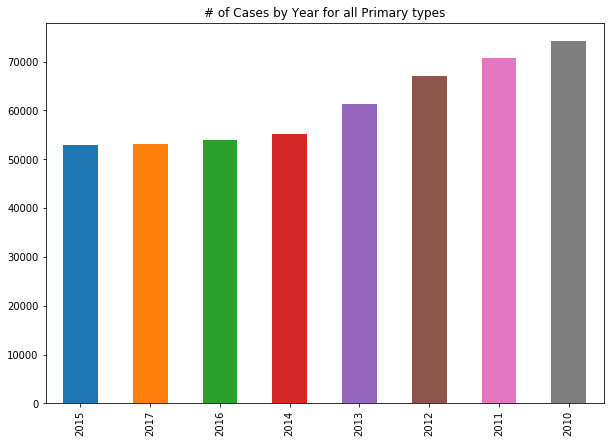

In [273]:
plt.figure(figsize=(10,7))
year_dist_df = Data["Year"].value_counts(ascending=True)
ax_1 = year_dist_df.plot(kind='bar')
plt.title("# of Cases by Year for all Primary types")
plt.show()

<Figure size 432x288 with 0 Axes>

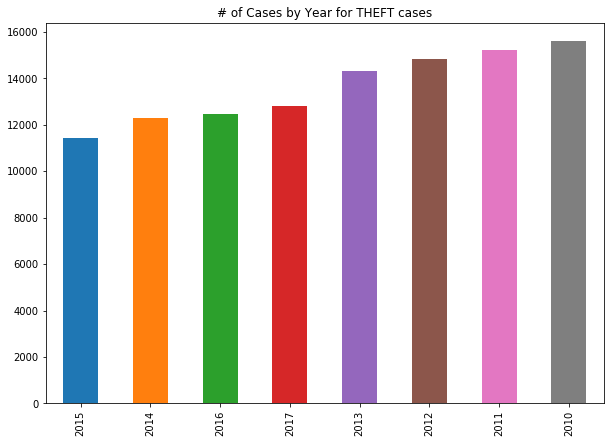

In [280]:
plt.clf()
plt.figure(figsize=(10,7))
data_theft = Data[Data['Primary Type'] == 1]
year_dist_df = data_theft['Year'].value_counts(ascending=True)
ax_1 = year_dist_df.plot(kind='bar')
plt.title("# of Cases by Year for THEFT cases")
plt.show()


<Figure size 432x288 with 0 Axes>

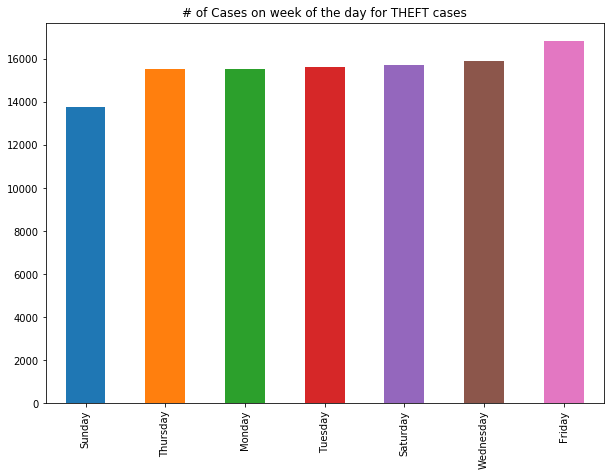

In [282]:
plt.clf()
plt.figure(figsize=(10,7))
data_theft = Data[Data['Primary Type'] == 1]
year_dist_df = data_theft['Day_week'].value_counts(ascending=True)
ax_1 = year_dist_df.plot(kind='bar')
plt.title("# of Cases on week of the day for THEFT cases")
plt.show()


In [ ]:
plt.clf()
plt.figure(figsize=(10,7))
data_theft = Data[Data['Primary Type'] == 1]
year_dist_df = data_theft['Month'].value_counts(ascending=True)
ax_1 = year_dist_df.plot(kind='bar')
plt.title("# of Cases by Month for THEFT cases")
plt.show()

In [129]:
convertCategory = ['Year','Primary Type','Month','Day_week' ]

#### Created Train and Test Data for various model iterations

In [130]:
for col in convertCategory:   
    Data[col] = Data[col].astype('category')

In [178]:
trainData = Data[Data['train_or_test'] == 'train']

In [179]:
testData = Data[Data['train_or_test'] == 'test']

In [180]:
trainData = trainData.drop(['train_or_test'], axis = 1)

In [181]:
testData = testData.drop(['train_or_test'], axis = 1)

In [182]:
trainData['Day_week'] = trainData['Day_week'].cat.codes

In [183]:
trainData['Day_week'] = trainData['Day_week'].astype('category')

In [184]:
testData['Day_week'] =testData['Day_week'].cat.codes

In [185]:
testData['Day_week'] =testData['Day_week'].astype('category')

In [186]:
trainData['FBI Code'] = trainData['FBI Code'].cat.codes

In [187]:
trainData['FBI Code'] = trainData['FBI Code'].astype('category')

In [188]:
testData['FBI Code'] = testData['FBI Code'].cat.codes

In [189]:
testData['FBI Code'] = testData['FBI Code'].astype('category')

#### Dropped null values from Training Data

In [198]:
trainData = trainData.dropna()

In [200]:
XTrain = trainData.loc[:,trainData.columns != 'Primary Type']

In [201]:
YTrain = trainData[['Primary Type']]

In [205]:
XTest = testData.loc[:,testData.columns != 'Primary Type']

In [206]:
yTest = testData[['Primary Type']]

### Model Evaluation: Comparing Various Metrics 

In [288]:
Accuracy = []

models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Multinomial Naive Bayes',
    'model': MultinomialNB(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0),
}
]
for m in models:
    model = m['model'] # select the model
    model.fit(XTrain, YTrain) # train the model
    y_pred=model.predict(XTest) # predict the test data
    accuracy = accuracy_score(yTest,y_pred)
    Accuracy.append(format(round(accuracy,2)))
    
    print(m['label'])
    print(classification_report(yTest, y_pred))


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression
              precision    recall  f1-score   support

           0       0.79      0.87      0.83     81737
           1       0.37      0.24      0.29     25266

   micro avg       0.72      0.72      0.72    107003
   macro avg       0.58      0.56      0.56    107003
weighted avg       0.69      0.72      0.70    107003



C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.85      0.72      0.78     81737
           1       0.39      0.58      0.47     25266

   micro avg       0.69      0.69      0.69    107003
   macro avg       0.62      0.65      0.62    107003
weighted avg       0.74      0.69      0.70    107003



C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     81737
           1       1.00      0.23      0.38     25266

   micro avg       0.82      0.82      0.82    107003
   macro avg       0.90      0.62      0.64    107003
weighted avg       0.85      0.82      0.77    107003



### Feature importance 

In [287]:
RF =  RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model = RF.fit(XTrain, YTrain) # train the model
y_pred=model.predict(XTest) # predict the test data
print(RF.feature_importances_)


C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[1.62630098e-01 1.57778579e-01 3.59349280e-02 6.63513168e-02
 5.18970328e-02 5.24897219e-01 1.36111062e-04 3.74714767e-04
 0.00000000e+00]


In [269]:
Accuracy = list(map(float, Accuracy))

Text(0,0.5,'Accuracy')

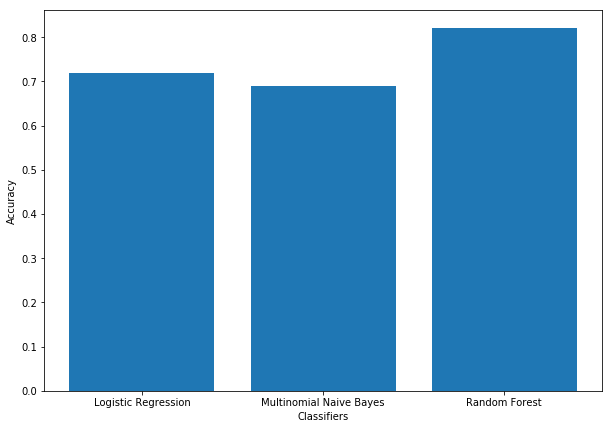

In [270]:
plt.figure(figsize=(10,7))
X= ['Logistic Regression', 'Multinomial Naive Bayes', 'Random Forest']
Y = Accuracy
plt.bar(X, Y)

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')


### AUC of Models

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


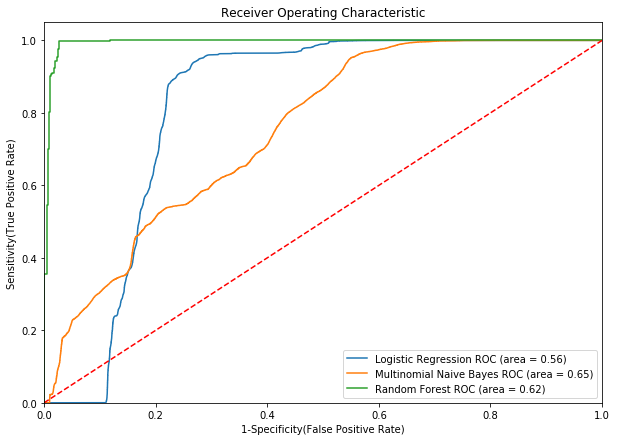

In [285]:
plt.figure(figsize=(10,7))
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Multinomial Naive Bayes',
    'model': MultinomialNB(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(XTrain, YTrain) # train the model
    y_pred=model.predict(XTest) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(yTest, model.predict_proba(XTest)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(yTest,model.predict(XTest))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display